# Demo

Dataset source: https://www.kaggle.com/ranjeetshrivastav/fraud-detection-dataset

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from nodevectors import Node2Vec
import xgboost as xgb
from fucc.inductive_step import inductive_pooling
from fucc.metrics import plot_ap, get_optimal_f1_cutoff, get_confusion_matrix
from sklearn.metrics import average_precision_score
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from fucc.pagerank import get_pagerank_suspicion_scores, inductive_step, splitDataFrameIntoSmaller, postprocessing_historical_edges
from fucc.utils import get_filename, export_suspicion_scores, import_suspicion_scores, multiprocessing
from tqdm import tqdm
from functools import partial
import datetime
import pickle

In [3]:
# Parameters
weighted = True
WORKERS = 12
lambdas = {'ST': 0.03, 'MT': 0.004, 'LT': 0.0001}
#lambdas = {'LT': 0.0001}
chunksize = 5000

In [4]:
output_path = ''

## Load Data

In [5]:
df = pd.read_json('/Users/raf/Dropbox/DOC/data/fraud_datasets/archive/transactions/transactions.txt',  lines=True, convert_dates=[4])

In [6]:
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4])

In [7]:
df = df.sort_values('transactionDateTime')
df.loc[:, 'TX_ID'] = range(df.shape[0])

In [8]:
df = df.rename(columns={"merchantName":"TERM_MIDUID", "customerId":"CARD_PAN_ID", "isFraud": "TX_FRAUD", "transactionDateTime":"TX_DATETIME"})

In [9]:
df_train = df.iloc[:320000]
df_val = df.iloc[320000:400000]
df_test = df.iloc[400000:500000]

In [10]:
personalization_nodes = list(df_train.index)

## Pagerank

In [11]:
%%time

dict_suspicion_scores = {}
dict_G = {}

for t, lambd in lambdas.items():
    suspicion_scores, G = get_pagerank_suspicion_scores(
                              df_train,
                              t=t,
                              lambd=lambd,
                              alpha=0.000085,
                              n_jobs=WORKERS,
                              personalization_nodes=personalization_nodes,
                              weighted=weighted)


    dict_suspicion_scores[t] = suspicion_scores
    dict_G[t] = G

INFO:root:Building network
INFO:root:Calculating edge weights for ST
INFO:root:Calculating some weights
INFO:root:ok, ST
INFO:root:Personalization
INFO:root:Building graph ST
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for MT
INFO:root:Calculating some weights
INFO:root:ok, MT
INFO:root:Personalization
INFO:root:Building graph MT
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished
INFO:root:Building network
INFO:root:Calculating edge weights for LT
INFO:root:Calculating some weights
INFO:root:ok, LT
INFO:root:Personalization
INFO:root:Building graph LT
INFO:root:Pagerank started


327266
5350


INFO:root:Pagerank finished


CPU times: user 1min 24s, sys: 3.95 s, total: 1min 28s
Wall time: 1min 30s


In [12]:
%%time
## Get suspicion scores for the validation part of the training data
data = df_val.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive val set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]

    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    #f#ilename = get_filename(filename_elements=[subset_name, t])
    
    dict_results[t] = result
    #result.to_csv(os.path.join(output_path, filename + '_output_val.csv'))

df_val_pagerank = df_val.copy()
for t, lamb in lambdas.items():
    #filename = get_filename(filename_elements=[subset_name, t])
    df_pagerank = dict_results[t]
    #df_pagerank = df_pagerank.set_index('TX_ID')
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_val_pagerank = df_val_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True) 

#filename = get_filename(filename_elements=[subset_name])
#df_val_pagerank.to_csv(os.path.join(output_path, subset_name + '_val_pagerank_inductive.csv'))

  0%|          | 0/41 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 20%|█▉        | 8/41 [01:27<02:39,  4.84s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started

INFO:root:post processing startedINFO:root:post processing started
 34%|███▍      | 14/41 [02:44<03:10,  7.05s/it]INFO:root:post processing started
INFO:root:post processing started
 39%|███▉      | 16/41 [02:48<02:10,  5.22s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 49%|████▉     | 20/41 [03:51<03:01,  8.65s/it]INFO:root:post processing s

CPU times: user 3min 6s, sys: 40 s, total: 3min 46s
Wall time: 17min 15s


In [13]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# Inductive test set processing

dict_results = {}
for t,lamb in lambdas.items():

    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    # split df in smaller chunks
    chunks = splitDataFrameIntoSmaller(data, chunkSize=2000)
    partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)

    result = multiprocessing(function=partial_inductive_step, chunks=chunks)
    dict_results[t] = result


df_test_pagerank = df_test.copy()
for t, lamb in lambdas.items():
    
    df_pagerank =  dict_results[t] 
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_test_pagerank = df_test_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)


  0%|          | 0/51 [00:00<?, ?it/s]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 14%|█▎        | 7/51 [01:16<04:18,  5.88s/it]INFO:root:post processing started

INFO:root:post processing startedINFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 29%|██▉       | 15/51 [02:22<02:31,  4.20s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 43%|████▎     | 22/51 [03:22<02:11,  4.53s/it]INFO:root:post processing started
INFO:root:post processing started
 45%|████▌     | 23/51 [03:28<02:22,  5.08s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 53%|█████▎    | 27/51 [04:

INFO:root:post processing started
 63%|██████▎   | 32/51 [05:17<01:19,  4.16s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 78%|███████▊  | 40/51 [06:28<00:47,  4.32s/it]INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
INFO:root:post processing started
 86%|████████▋ | 44/51 [07:32<01:04,  9.21s/it]INFO:root:post processing started
INFO:root:post processing started
100%|██████████| 51/51 [08:10<00:00,  9.62s/it]


CPU times: user 3min 59s, sys: 45.6 s, total: 4min 44s
Wall time: 22min 47s


In [14]:
%%time
# We only need these columns from data
data = df_test.set_index('TX_ID')
data = data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]

# We only need these columns from historical data
historical_data = df_train.set_index('TX_ID')
historical_data = historical_data.loc[:, ['CARD_PAN_ID', 'TERM_MIDUID']]


# transductive train set processing
dict_results = {}
for t, lamb in lambdas.items():
    print(t)
    suspicion_scores, G = dict_suspicion_scores[t], dict_G[t]


    #Split historical dataset into smaller chunks
    chunks = splitDataFrameIntoSmaller(historical_data, chunkSize=5000)
    partial_postprocessing_historical_edges = partial(postprocessing_historical_edges, suspicion_scores=suspicion_scores, t=t)
    #partial_inductive_step = partial(inductive_step, historical_edges=historical_data, suspicion_scores=suspicion_scores, G=G, t=t)
    
    result = multiprocessing(function=partial_postprocessing_historical_edges, chunks=chunks)
    dict_results[t] = result

df_train_pagerank = df_train.copy()
# Load and join ST, MT, LT data for df_train and df_train
for t, lamb in lambdas.items():
    df_pagerank = dict_results[t]
    df_pagerank = df_pagerank.filter(regex='SC_*')
    df_train_pagerank = df_train_pagerank.merge(df_pagerank, left_on='TX_ID', right_index=True)

ST


100%|██████████| 65/65 [02:03<00:00,  1.90s/it]


MT


100%|██████████| 65/65 [01:47<00:00,  1.66s/it]

LT



100%|██████████| 65/65 [01:56<00:00,  1.79s/it]


CPU times: user 12.5 s, sys: 7 s, total: 19.5 s
Wall time: 5min 53s


## XGBoost Classifier

In [15]:
df_train = df_train_pagerank
df_val = df_val_pagerank
df_test = df_test_pagerank

In [16]:
pagerank_features = list(df_train.filter(regex='SC').columns)

In [17]:
X_train = df_train[pagerank_features]
X_val = df_val[pagerank_features]
y_train = df_train.TX_FRAUD
y_val = df_val.TX_FRAUD

X_test = df_test[pagerank_features]
y_test = df_test.TX_FRAUD

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [18]:
xgb_params = {
    'eval_metric': ['auc','aucpr', 'logloss'],
    'objective':'binary:logistic',
    'n_estimators': 300,
    'n_jobs':8,
    'learning_rate':0.1,
    'seed':42,
    'colsample_bytree':0.6,
    'colsample_bylevel':0.9,
    'subsample':0.9
}

In [19]:
model = xgb.train(xgb_params, dtrain, num_boost_round=xgb_params['n_estimators'], evals=[(dval, 'val'), (dtrain, 'train')], early_stopping_rounds=int(xgb_params['n_estimators']/2))

[14:53:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	val-auc:0.59999	val-aucpr:0.02466	val-logloss:0.63629	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.59783
[1]	val-auc:0.67345	val-aucpr:0.03429	val-logloss:0.56901	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.52519
[2]	val-auc:0.68053	val-aucpr:0.04282	val-logloss:0.50525	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.46464
[3]	val-auc:0.68053	val-aucpr:0.04282	val-logloss:0.47984	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.40830
[4]	val-auc:0.68053	val-aucpr:0.04282	val-logloss:0.46087	train-auc:1.00000	train-aucpr:1.00000	train-logloss:0.36024
[5]	val-auc:0.68730	val-aucpr:0.04915	val-logl

[66]	val-auc:0.69687	val-aucpr:0.05250	val-logloss:0.69873	train-auc:1.00002	train-aucpr:1.00000	train-logloss:0.00160
[67]	val-auc:0.69692	val-aucpr:0.05281	val-logloss:0.69009	train-auc:1.00003	train-aucpr:1.00000	train-logloss:0.00157
[68]	val-auc:0.69728	val-aucpr:0.05314	val-logloss:0.68315	train-auc:1.00004	train-aucpr:1.00000	train-logloss:0.00155
[69]	val-auc:0.69703	val-aucpr:0.05392	val-logloss:0.67485	train-auc:1.00004	train-aucpr:1.00000	train-logloss:0.00153
[70]	val-auc:0.69703	val-aucpr:0.05392	val-logloss:0.69360	train-auc:1.00004	train-aucpr:1.00000	train-logloss:0.00138
[71]	val-auc:0.69679	val-aucpr:0.05389	val-logloss:0.68509	train-auc:1.00005	train-aucpr:1.00000	train-logloss:0.00136
[72]	val-auc:0.69679	val-aucpr:0.05388	val-logloss:0.70384	train-auc:1.00005	train-aucpr:1.00000	train-logloss:0.00123
[73]	val-auc:0.69681	val-aucpr:0.05389	val-logloss:0.72213	train-auc:1.00005	train-aucpr:1.00000	train-logloss:0.00112
[74]	val-auc:0.69873	val-aucpr:0.05491	val-loglo

[135]	val-auc:0.69719	val-aucpr:0.05821	val-logloss:1.26524	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00003
[136]	val-auc:0.69719	val-aucpr:0.05819	val-logloss:1.28070	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00003
[137]	val-auc:0.69718	val-aucpr:0.05828	val-logloss:1.27990	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00003
[138]	val-auc:0.69599	val-aucpr:0.05820	val-logloss:1.28896	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00003
[139]	val-auc:0.69592	val-aucpr:0.05826	val-logloss:1.28817	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00003
[140]	val-auc:0.69592	val-aucpr:0.05827	val-logloss:1.30321	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00003
[141]	val-auc:0.69592	val-aucpr:0.05826	val-logloss:1.31802	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00002
[142]	val-auc:0.69592	val-aucpr:0.05827	val-logloss:1.33260	train-auc:1.00021	train-aucpr:1.00000	train-logloss:0.00002
[143]	val-auc:0.69592	val-aucpr:0.05826	

[204]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54288	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[205]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54284	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[206]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54283	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[207]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54287	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[208]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54285	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[209]	val-auc:0.69680	val-aucpr:0.05913	val-logloss:1.54286	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[210]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54284	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[211]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54280	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[212]	val-auc:0.69680	val-aucpr:0.05912	

[273]	val-auc:0.69680	val-aucpr:0.05909	val-logloss:1.54262	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[274]	val-auc:0.69680	val-aucpr:0.05911	val-logloss:1.54267	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[275]	val-auc:0.69680	val-aucpr:0.05910	val-logloss:1.54269	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[276]	val-auc:0.69680	val-aucpr:0.05909	val-logloss:1.54274	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[277]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54279	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[278]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54284	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[279]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54284	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[280]	val-auc:0.69680	val-aucpr:0.05912	val-logloss:1.54280	train-auc:1.00023	train-aucpr:1.00000	train-logloss:0.00001
[281]	val-auc:0.69680	val-aucpr:0.05913	

In [20]:
y_pred_proba = model.predict(dtest)

## Evaluation

In [21]:
ap = average_precision_score(y_test, y_pred_proba)
print("Average Precision: ", np.round(ap,2))

Average Precision:  0.06


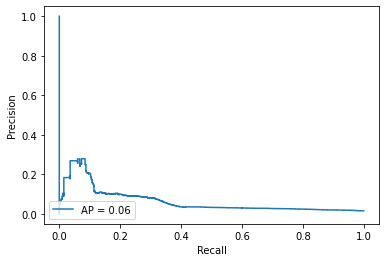

In [22]:
fig = plot_ap(y_test, y_pred_proba)

In [23]:
optimal_threshold, optimal_f1_score = get_optimal_f1_cutoff(y_test, y_pred_proba)
print("F1 Score: ", np.round(optimal_f1_score, 4))

F1 Score:  0.0706


In [24]:
cm = get_confusion_matrix(y_test, y_pred_proba, optimal_threshold)
print("Confusion Matrix: \n", cm)

Confusion Matrix: 
 [[83475 14980]
 [  940   605]]


In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
roc_auc_score(y_test, y_pred_proba)

0.7178016865425187